<a href="https://colab.research.google.com/github/shoulderhu/colab-tensorflow-ipy/blob/master/NTPU_05_Network_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Training Techniques and ResNet

## Part 0: Preliminaries

In [0]:
!pip uninstall -y tensorflow

In [0]:
!pip install -U tensorflow-gpu==2.0.0-beta1

Requirement already up-to-date: tensorflow-gpu==2.0.0-beta1 in /usr/local/lib/python3.6/dist-packages (2.0.0b1)


In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Part 1: Activation Functions

Let's list all the activation functions.

In [0]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

Certain advanced activations are treated as layers in Keras. For these, do not specify any specific activation for the preceding layer. Simply add these advanced activations as a layer after a normal layer in your model.

In [0]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

### Softmax

We've used the softmax activation many times now without explaining what it is. So let's talk about it now. Let's say we have a *k* class classification problem. For multinomial classifcation problems, we often use the softmax activation function to calculate the probability that an input belongs to a certain class, p_k. 

The way softmax works is, for each class, we will have a score:

![alt text](https://drive.google.com/uc?id=1CN_oTjvwxTU_Nu4y1W8bipFv46UhEHmx)

If you look at this closely, the score is just the weight multiplied by the input (so basically just what the neuron does before activation).

Now, the probability that the input belongs to class *k* is:

![alt text](https://drive.google.com/uc?id=1rSxk2Gp-VE2BFE_dzHtBRi8w-NushF8Z)

where *K* is the total number of classes. So basically you divide the exponential score of this class by the sum of all the output exponentials of each class. This is different than, say, the linear ratio between class *k*'s score and the sum of all the scores. Namely, the softmax function makes the probability of the higher scored classes **further** apart from the ones with lower scores.

### Leaky ReLU

Let's revisit the fashion MNIST problem using leaky ReLU.

In [0]:
# define the leaky relu activation function
z = np.linspace(-5, 5, 200)

def relu(z):
    return np.where(z < 0, 0, z)
  
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

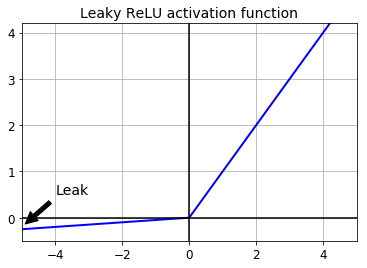

In [0]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [0]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

W0708 16:29:38.266940 140483582592896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 77us/sample - loss: 1.2810 - accuracy: 0.6253 - val_loss: 0.8872 - val_accuracy: 0.7192
Epoch 2/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.7957 - accuracy: 0.7371 - val_loss: 0.7128 - val_accuracy: 0.7676
Epoch 3/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.6818 - accuracy: 0.7721 - val_loss: 0.6365 - val_accuracy: 0.7902
Epoch 4/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.6222 - accuracy: 0.7934 - val_loss: 0.5898 - val_accuracy: 0.8082
Epoch 5/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5832 - accuracy: 0.8067 - val_loss: 0.5584 - val_accuracy: 0.8166
Epoch 6/10
55000/55000 [==============================] - 4s 68us/sample - loss: 0.5553 - accuracy: 0.8165 - val_loss: 0.5358 - val_accuracy: 0.8248
Epoch 7/10
55000/55000 [==============================] -

### SELU
SELU is a scaled ELU activation function. It's special because for a network consisting of purely dense layers, the SELU activation helps the outputs *self-normalize*. That means, the output will preserve mean 0 and std 1 during training, which automatically deals with the vanishing gradient problem. Sufficiently deep dense nets will therefore work nicely with SELU.

In [0]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [0]:
# define the elu and selu activations
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)
  
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

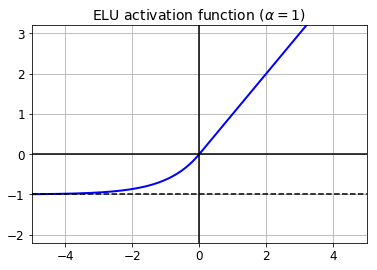

In [0]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

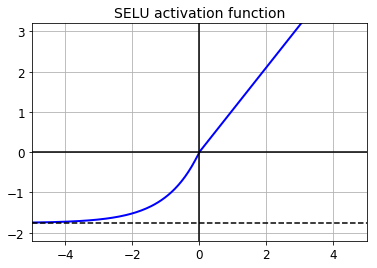

In [0]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [0]:
def try_1000_activations(activation):
  np.random.seed(42)
  Z = np.random.normal(size=(500, 100)) # standardized inputs
  for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = activation(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
      print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

In [0]:
try_1000_activations(selu)

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [0]:
try_1000_activations(relu)

Layer 0: mean 0.40, std deviation 0.58
Layer 100: mean 0.00, std deviation 0.00
Layer 200: mean 0.00, std deviation 0.00
Layer 300: mean 0.00, std deviation 0.00
Layer 400: mean 0.00, std deviation 0.00
Layer 500: mean 0.00, std deviation 0.00
Layer 600: mean 0.00, std deviation 0.00
Layer 700: mean 0.00, std deviation 0.00
Layer 800: mean 0.00, std deviation 0.00
Layer 900: mean 0.00, std deviation 0.00


In [0]:
try_1000_activations(leaky_relu)

Layer 0: mean 0.39, std deviation 0.59
Layer 100: mean 0.00, std deviation 0.00
Layer 200: mean 0.00, std deviation 0.00
Layer 300: mean 0.00, std deviation 0.00
Layer 400: mean 0.00, std deviation 0.00
Layer 500: mean 0.00, std deviation 0.00
Layer 600: mean 0.00, std deviation 0.00
Layer 700: mean 0.00, std deviation 0.00
Layer 800: mean 0.00, std deviation 0.00
Layer 900: mean 0.00, std deviation 0.00


In [0]:
try_1000_activations(elu)

Layer 0: mean 0.16, std deviation 0.79
Layer 100: mean -0.00, std deviation 0.02
Layer 200: mean -0.00, std deviation 0.01
Layer 300: mean -0.00, std deviation 0.00
Layer 400: mean 0.00, std deviation 0.00
Layer 500: mean -0.00, std deviation 0.00
Layer 600: mean 0.00, std deviation 0.00
Layer 700: mean 0.00, std deviation 0.00
Layer 800: mean -0.00, std deviation 0.00
Layer 900: mean -0.00, std deviation 0.00


Let's try using the SELU activation on fashion MNIST.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

Before training it, remember to scale the inputs to mean 0 and std 1 first.

In [0]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [0]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 34s 617us/sample - loss: 1.2710 - accuracy: 0.5080 - val_loss: 1.0708 - val_accuracy: 0.5594
Epoch 2/5
55000/55000 [==============================] - 29s 534us/sample - loss: 0.8509 - accuracy: 0.6779 - val_loss: 0.6995 - val_accuracy: 0.7412
Epoch 3/5
55000/55000 [==============================] - 30s 537us/sample - loss: 0.7195 - accuracy: 0.7356 - val_loss: 0.7018 - val_accuracy: 0.7498
Epoch 4/5
55000/55000 [==============================] - 30s 538us/sample - loss: 0.7286 - accuracy: 0.7386 - val_loss: 0.8595 - val_accuracy: 0.7112
Epoch 5/5
55000/55000 [==============================] - 29s 535us/sample - loss: 0.6805 - accuracy: 0.7522 - val_loss: 0.5807 - val_accuracy: 0.8048


Let's do the same thing with ReLU to compare.

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [0]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 21s 381us/sample - loss: 1.8279 - accuracy: 0.2662 - val_loss: 1.2287 - val_accuracy: 0.4560
Epoch 2/5
55000/55000 [==============================] - 19s 339us/sample - loss: 1.1299 - accuracy: 0.5147 - val_loss: 1.0086 - val_accuracy: 0.5574
Epoch 3/5
55000/55000 [==============================] - 19s 340us/sample - loss: 1.0200 - accuracy: 0.5735 - val_loss: 1.0418 - val_accuracy: 0.5538
Epoch 4/5
55000/55000 [==============================] - 19s 341us/sample - loss: 0.9309 - accuracy: 0.6126 - val_loss: 0.7873 - val_accuracy: 0.6586
Epoch 5/5
55000/55000 [==============================] - 19s 343us/sample - loss: 0.7924 - accuracy: 0.6719 - val_loss: 0.7257 - val_accuracy: 0.7084


## Part 2: Batch Normalization

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_205 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_206 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_207 (Dense)            (None, 10)               

In [0]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [0]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.8756 - accuracy: 0.7140 - val_loss: 0.5515 - val_accuracy: 0.8216
Epoch 2/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.5765 - accuracy: 0.8033 - val_loss: 0.4743 - val_accuracy: 0.8434
Epoch 3/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.5146 - accuracy: 0.8213 - val_loss: 0.4382 - val_accuracy: 0.8534
Epoch 4/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.4821 - accuracy: 0.8322 - val_loss: 0.4171 - val_accuracy: 0.8594
Epoch 5/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.4590 - accuracy: 0.8403 - val_loss: 0.4002 - val_accuracy: 0.8658
Epoch 6/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.4428 - accuracy: 0.8459 - val_loss: 0.3884 - val_accuracy: 0.8690
Epoch 7/10
55000/55000 [===========================

Let's try putting the batch normalization before the activations.

In [0]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])


history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 115us/sample - loss: 0.8618 - accuracy: 0.7093 - val_loss: 0.5659 - val_accuracy: 0.8084
Epoch 2/10
55000/55000 [==============================] - 6s 107us/sample - loss: 0.5809 - accuracy: 0.8008 - val_loss: 0.4832 - val_accuracy: 0.8350
Epoch 3/10
55000/55000 [==============================] - 6s 108us/sample - loss: 0.5161 - accuracy: 0.8199 - val_loss: 0.4463 - val_accuracy: 0.8474
Epoch 4/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4850 - accuracy: 0.8301 - val_loss: 0.4255 - val_accuracy: 0.8550
Epoch 5/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4580 - accuracy: 0.8406 - val_loss: 0.4109 - val_accuracy: 0.8594
Epoch 6/10
55000/55000 [==============================] - 6s 102us/sample - loss: 0.4410 - accuracy: 0.8458 - val_loss: 0.3977 - val_accuracy: 0.8620
Epoch 7/10
55000/55000 [===========================

## Part 3: Gradient Clipping

In [0]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

optimizer = keras.optimizers.SGD(clipnorm=1.0)

#model.compile(loss="mse", optimizer=optimizer)

## Part 4: Transfer learning

Using the fashion MNIST dataset, let's pretrain a network to classify 8 classes, then reuse parts of that network to perform binary classification on the remaining 2 classes.

Let's start by splitting the dataset into two parts.

*   ```X_train_A```: all classes except class 5 and 6 (sandals and shirts)
*   ```X_train_B```: just the first 200 images of sandals and shirts.

We also split the validation and test sets.

In [0]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

# reshape the inputs for CNN
data = [X_train_A, X_valid_A, X_test_A, X_train_B, X_valid_B, X_test_B]
for i in range(len(data)):
  data[i].resize(*data[i].shape, 1)

In [0]:
X_train_A.shape

(43986, 28, 28, 1)

In [0]:
X_train_B.shape

(200, 28, 28, 1)

In [0]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [0]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                       kernel_size=3, activation='relu', padding="SAME")

model_A = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=8, activation='softmax'),
])

In [0]:
model_A.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=10, validation_data=[X_valid_A, y_valid_A])
score = model_A.evaluate(X_test_A, y_test_A)

Train on 43986 samples, validate on 4014 samples
Epoch 1/10
43986/43986 [==============================] - 10s 236us/sample - loss: 0.7185 - accuracy: 0.7476 - val_loss: 0.4156 - val_accuracy: 0.8498
Epoch 2/10
43986/43986 [==============================] - 8s 191us/sample - loss: 0.3727 - accuracy: 0.8672 - val_loss: 0.3338 - val_accuracy: 0.8802
Epoch 3/10
43986/43986 [==============================] - 8s 191us/sample - loss: 0.3077 - accuracy: 0.8904 - val_loss: 0.2714 - val_accuracy: 0.9041
Epoch 4/10
43986/43986 [==============================] - 8s 191us/sample - loss: 0.2730 - accuracy: 0.9029 - val_loss: 0.2376 - val_accuracy: 0.9168
Epoch 5/10
43986/43986 [==============================] - 8s 188us/sample - loss: 0.2472 - accuracy: 0.9127 - val_loss: 0.2389 - val_accuracy: 0.9163
Epoch 6/10
43986/43986 [==============================] - 8s 187us/sample - loss: 0.2306 - accuracy: 0.9178 - val_loss: 0.2183 - val_accuracy: 0.9215
Epoch 7/10
43986/43986 [==========================

In [0]:
model_A.save("my_model_A.h5")

In [0]:
model_B = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=1, activation='sigmoid'),
])

In [0]:
model_B.compile(loss="binary_crossentropy",
                 optimizer="sgd", metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=10, validation_data=[X_valid_B, y_valid_B])
score = model_B.evaluate(X_test_B, y_test_B)

Train on 200 samples, validate on 986 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/sample - loss: 0.6898 - accuracy: 0.4950 - val_loss: 0.6869 - val_accuracy: 0.5000
Epoch 2/10
200/200 [==============================] - 0s 630us/sample - loss: 0.6850 - accuracy: 0.5050 - val_loss: 0.6826 - val_accuracy: 0.5304
Epoch 3/10
200/200 [==============================] - 0s 593us/sample - loss: 0.6807 - accuracy: 0.5400 - val_loss: 0.6784 - val_accuracy: 0.7373
Epoch 4/10
200/200 [==============================] - 0s 619us/sample - loss: 0.6763 - accuracy: 0.7500 - val_loss: 0.6740 - val_accuracy: 0.7414
Epoch 5/10
200/200 [==============================] - 0s 601us/sample - loss: 0.6716 - accuracy: 0.7550 - val_loss: 0.6689 - val_accuracy: 0.7110
Epoch 6/10
200/200 [==============================] - 0s 586us/sample - loss: 0.6660 - accuracy: 0.7950 - val_loss: 0.6631 - val_accuracy: 0.6714
Epoch 7/10
200/200 [==============================] - 0s 580us/sample - loss: 0.

Load model A and replace the output layer.

In [0]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras. models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

Because the layers for ```model_B_on_A``` are shared with ```model_A```, training performed on ```model_B_on_A``` will also affect ```model_A```. If  you want to avoid that, you can make a copy of ```model_A```, which will not be affected.

In [0]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

Let's freeze all of the reused layers first.

In [0]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [0]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/4
200/200 [==============================] - 0s 2ms/sample - loss: 1.1990 - accuracy: 0.5050 - val_loss: 1.0853 - val_accuracy: 0.5010
Epoch 2/4
200/200 [==============================] - 0s 514us/sample - loss: 1.0411 - accuracy: 0.5000 - val_loss: 0.9422 - val_accuracy: 0.5020
Epoch 3/4
200/200 [==============================] - 0s 513us/sample - loss: 0.9031 - accuracy: 0.5050 - val_loss: 0.8110 - val_accuracy: 0.5112
Epoch 4/4
200/200 [==============================] - 0s 531us/sample - loss: 0.7786 - accuracy: 0.5200 - val_loss: 0.7097 - val_accuracy: 0.5345
Train on 200 samples, validate on 986 samples
Epoch 1/16
200/200 [==============================] - 0s 2ms/sample - loss: 0.5634 - accuracy: 0.6800 - val_loss: 0.3850 - val_accuracy: 0.8377
Epoch 2/16
200/200 [==============================] - 0s 611us/sample - loss: 0.3238 - accuracy: 0.8900 - val_loss: 0.2790 - val_accuracy: 0.9138
Epoch 3/16
200/200 [====================

In [0]:
model_B.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 83us/sample - loss: 0.6219 - accuracy: 0.8860


[0.6219099011421204, 0.886]

In [0]:
model_B_on_A.evaluate(X_test_B, y_test_B)

2000/2000 [==============================] - 0s 101us/sample - loss: 0.0557 - accuracy: 0.9945


[0.05565613985061645, 0.9945]